# 70.3 Half Triathlon Santa Cruz 2015-2018
## Data Preview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import spline

import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
tri_df = pd.read_csv('./data/tri_santa_cruz_2015-2018.csv')
print("The shape of this original dataframe is ", tri_df.shape)

The shape of this original dataframe is  (8149, 12)


In [3]:
tri_df.head()

,Name,Country,DivRank,GenderRank,OverallRank,Swim,Bike,Run,Finish,Points,Gender,AgeGroup
0,"Delisle, Laurence",USA,1,1,32,00:25:05,02:29:52,01:38:01,04:38:55,3500,F,18-24
1,"Atkins, Wendy",USA,2,35,290,00:35:54,02:51:01,01:46:34,05:20:47,2746,F,18-24
2,"Swarovski, Michelle",USA,3,41,324,00:35:42,02:56:02,01:46:55,05:25:06,2668,F,18-24
3,"Connor, Gabi",USA,4,42,325,00:38:48,02:53:05,01:45:11,05:25:08,2668,F,18-24
4,"Hoose, Kelly",USA,5,59,396,00:41:15,03:00:50,01:42:39,05:33:36,2515,F,18-24


In [4]:
tri_df.tail()

,Name,Country,DivRank,GenderRank,OverallRank,Swim,Bike,Run,Finish,Points,Gender,AgeGroup
8144,"Snyder, Dennis",USA,---,---,---,00:32:43,---,---,DNF,---,M,70-74
8145,"Mcclure, Robert",USA,1,936,1269,00:43:16,03:20:40,02:39:06,06:56:53,3500,M,75-79
8146,"Mine, Warren",USA,2,998,1374,00:48:32,03:33:55,02:32:47,07:18:38,3108,M,75-79
8147,"Cook, Warren",USA,---,---,---,01:08:39,04:01:08,---,DNF,---,M,75-79
8148,"Mehl, Wayne",USA,---,---,---,---,---,---,DNS,---,M,80-84


## Data Pre-processing

In [5]:
# if df['Finish'] == 'DNS' or 'DNF' or 'DQ', drop the record
# DNS = Do Not Start; DNF = Do Not Finish; DQ = Disqualified

drop_cond = ['DNS', 'DNF', 'DQ']

df = tri_df[~tri_df.Finish.isin(drop_cond)]
print(df.shape)

(6572, 12)


In [118]:
has_run = df['Run'].str.contains(":") == True
has_swim = df['Swim'].str.contains(":") == True
has_bike = df['Bike'].str.contains(":") == True

df = df[has_run & has_swim & has_bike]
print(df.shape)

(6560, 14)


In [14]:
uniq = len(df['Name'].unique())
uniq

5415

In [20]:
# How many athletes attended the race more than once.

print(1 - uniq * 1.0 / df.shape[0])

0.17454268292682928


## Let's see the distribution!

In [21]:
male = df['Gender'] == 'M'
female = df['Gender'] =='F'

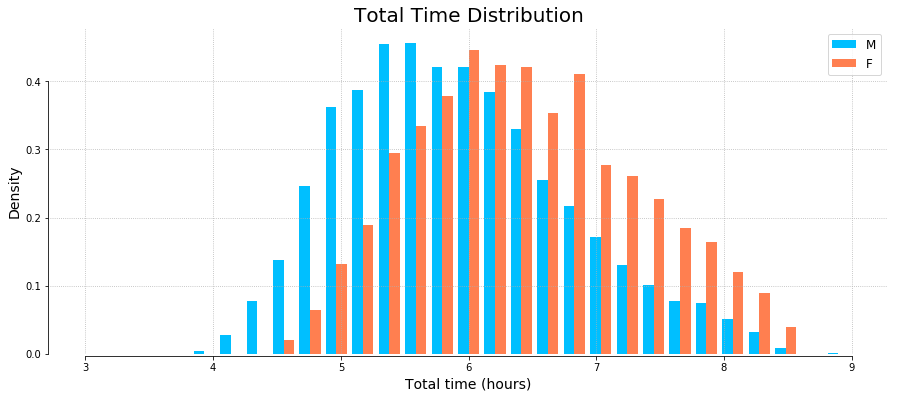

In [22]:
# Total time distribution according to gender

m = df[male]['Finish'] / pd.Timedelta(hours=1)
f = df[female]['Finish']/ pd.Timedelta(hours=1)

bins = np.linspace(3, 9, 30)
ax_fontsize = 14

# Plot histogram of total time for female and male
fig = plt.figure(figsize=(15, 6))
plt.hist([m, f], bins, label=('M','F'), density=True, color=('deepskyblue', 'coral'))

plt.xlabel('Total time (hours)', fontsize = ax_fontsize)
plt.ylabel('Density', fontsize = ax_fontsize)
plt.xticks(fontsize = ax_fontsize)
plt.yticks(fontsize = ax_fontsize)

plt.grid(linestyle='dotted')
plt.legend(loc=0, fontsize = ax_fontsize - 2)
sns.despine(offset=2, trim=True)

plt.title('Total Time Distribution', fontsize = ax_fontsize + 6)
plt.savefig('totaltime_dist.png', dpi=800)

plt.show()

In [34]:
m_des = pd.DataFrame(m.describe())

In [35]:
f_des = pd.DataFrame(f.describe())

In [36]:
print(pd.merge(m_des, f_des, left_index=True, right_index=True, suffixes=('', '2')))

            Finish      Finish2
count  4620.000000  1940.000000
mean      5.909297     6.440245
std       0.876477     0.869169
min       3.983056     4.466944
25%       5.253472     5.794792
50%       5.820000     6.364444
75%       6.451806     7.061667
max       8.837778     9.098333


In [28]:
type(m.describe())

pandas.core.series.Series

In [38]:
# Ratio of female vs male
print(1940/6572)
print(6572/1940)

0.2951917224589166
3.3876288659793814


In [39]:
df['Finish_long'] = df['Finish'] / pd.Timedelta(hours=1)

large_age = []
for index, row in df.iterrows():
    age = int(row['AgeGroup'][-2:])
    large_age.append(age)
df['LargeAge'] = large_age

twothree = df[df['LargeAge'] < 40]
fourfive = df[(df['LargeAge'] > 40) & (df['LargeAge'] < 60)]
sixseven = df[df['LargeAge'] > 60]

fourfive.head()

,Name,Country,DivRank,GenderRank,OverallRank,Swim,Bike,Run,Finish,Points,Gender,AgeGroup,Finish_long,LargeAge
338,"Adair, Audra",USA,1,4,86,00:35:32,02:37:24,01:30:54,04:52:02,3500,F,40-44,4.867222,44
339,"Samansky, Andrea",USA,2,8,128,00:32:14,02:41:16,01:35:45,04:58:27,3384,F,40-44,4.974167,44
340,"Hassett, Deirdre",IRL,3,16,198,00:39:05,02:42:54,01:37:41,05:08:09,3209,F,40-44,5.135833,44
341,"Barber, Nicky",GBR,4,18,202,00:34:39,02:44:07,01:42:03,05:09:10,3191,F,40-44,5.152778,44
342,"Micoleau, Sandrine",USA,5,22,209,00:34:48,02:42:37,01:43:05,05:09:52,3179,F,40-44,5.164444,44


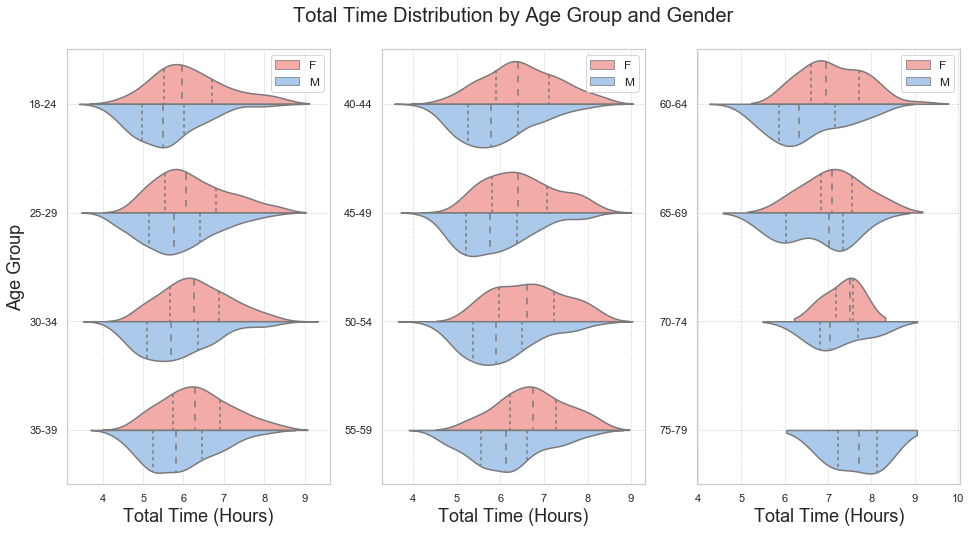

In [41]:
def plot_violin(df_plot, axes, ii):
    ax_cur = axes[ii]
    sns.violinplot(y="AgeGroup", x="Finish_long", hue="Gender",
                   data=df_plot, split=True, inner="quart",
                   palette={"M": "b", "F": "r"}, ax=ax_cur)
    ax_cur.set_xlabel('Total Time (Hours)', fontsize = ax_fontsize + 4)
    if ii == 0:
        ax_cur.set_ylabel("Age Group", fontsize = ax_fontsize + 4)
    else:
        ax_cur.set_ylabel('')
    if ii == 1:
        ax_cur.set_title('Total Time Distribution by Age Group and Gender', fontsize = ax_fontsize + 6, y=1.05)
    ax_cur.grid(linestyle='dotted')
    ax_cur.legend(loc=0, fontsize = ax_fontsize - 2)


df_list = [twothree, fourfive, sixseven]

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
# fig.figsize=(10, 20)
sns.set(style="whitegrid", palette="pastel", color_codes=True)

for ii, df_plot in enumerate(df_list):
    plot_violin(df_plot, axes, ii)

# plt.title('Total Time Distribution by Age Group and Gender', fontsize = ax_fontsize + 6, y=1.025)
plt.savefig('totaltime_violin_allgroup.png', dpi=800)

plt.show()


In [94]:
df2 = df[['AgeGroup', 'Finish_long']].groupby('AgeGroup').describe().reset_index()

In [95]:
print(df2.shape)
df2.head(15)

(12, 9)


AgeGroup Finish_long                                                    \
                  count      mean       std       min       25%       50%   
0     18-24       219.0  5.762698  0.891456  4.010833  5.117222  5.668889   
1     25-29       784.0  5.963504  0.918979  3.983056  5.319583  5.847500   
2     30-34      1058.0  5.963603  0.918391  4.001111  5.272917  5.905278   
3     35-39      1072.0  6.013985  0.876162  4.145278  5.330972  5.944583   
4     40-44      1065.0  6.067797  0.888722  4.010556  5.393611  5.989167   
5     45-49       972.0  6.018057  0.876623  4.160000  5.351111  5.916250   
6     50-54       726.0  6.184777  0.893838  4.131667  5.523681  6.067083   
7     55-59       398.0  6.296595  0.868561  4.440833  5.634306  6.259444   
8     60-64       194.0  6.646813  0.853611  4.881667  5.994931  6.540278   
9     65-69        50.0  6.856111  0.777248  5.356944  6.225347  7.042778   
10    70-74        18.0  7.242377  0.602865  6.239722  6.832083  7.137222   
11    75-79         4.0  7.632083  0.599133  6.948056  7.219931  7.720556   

                        
         75%       max  
0   6.288889  8.342222  
1   6.527569  8.441111  
2   6.563958  8.837778  
3   6.612986  8.521389  
4   6.667500  8.499722  
5   6.553403  8.454722  
6   6.795208  8.540556  
7   6.877917  8.346944  
8   7.311111  9.098333  
9   7.370833  8.393611  
10  7.634931  8.301111  
11  8.132708  8.139167

In [96]:
df2.columns
df2.columns = df2.columns.droplevel(0)
df2.rename(columns={'':'AgeGroup'}, inplace=True)
df2.head()

,AgeGroup,count,mean,std,min,25%,50%,75%,max
0,18-24,219.0,5.762698,0.891456,4.010833,5.117222,5.668889,6.288889,8.342222
1,25-29,784.0,5.963504,0.918979,3.983056,5.319583,5.847500,6.527569,8.441111
2,30-34,1058.0,5.963603,0.918391,4.001111,5.272917,5.905278,6.563958,8.837778
3,35-39,1072.0,6.013985,0.876162,4.145278,5.330972,5.944583,6.612986,8.521389
4,40-44,1065.0,6.067797,0.888722,4.010556,5.393611,5.989167,6.667500,8.499722


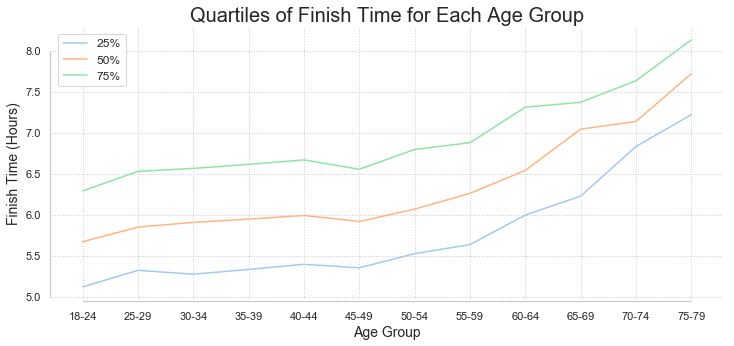

In [112]:
# fig = plt.figure(figsize=(15, 6))

df2.plot(figsize=(12,5), use_index=True, y=["25%", "50%", "75%"], kind="line")

plt.xlabel('Age Group', fontsize = ax_fontsize)
plt.ylabel('Finish Time (Hours)', fontsize = ax_fontsize)
# plt.xticks(df2['AgeGroup'], fontsize = ax_fontsize)
xl = list(df2['AgeGroup'])
plt.xticks(df2.index.tolist(), labels=xl,rotation='vertical')
plt.yticks(fontsize = ax_fontsize)

plt.grid(linestyle='dotted')
plt.legend(loc=0, fontsize = ax_fontsize - 2)
sns.despine(offset=2, trim=True)

plt.title('Quartiles of Finish Time for Each Age Group', fontsize = ax_fontsize + 6)
plt.savefig('totaltime_line_agegroup.png', dpi=800)

plt.show()

In [104]:
list(df2['AgeGroup'])

['18-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',
 '75-79']

# Plot My Age Group, 30-34

In [119]:
thirty = df['AgeGroup'] == '30-34'

thirty_df = df[thirty]
print(thirty_df.shape)
thirty_df.head()

(1058, 14)


,Name,Country,DivRank,GenderRank,OverallRank,Swim,Bike,Run,Finish,Points,Gender,AgeGroup,Finish_long,LargeAge
96,"Kielar, Kayla",USA,1,6,102,00:31:36,02:38:11,01:36:15,04:53:52,3500,F,30-34,4.897778,34
97,"Crum, Alia",USA,2,9,136,00:35:39,02:36:23,01:40:36,04:59:36,3396,F,30-34,4.993333,34
98,"Liebner, Christina",USA,3,17,199,00:33:52,02:45:36,01:40:00,05:08:24,3238,F,30-34,5.140000,34
99,"Lai, Patricia",HKG,4,20,205,00:31:40,02:53:16,01:34:21,05:09:38,3216,F,30-34,5.160556,34
100,"Mellican, Jenesse",AUS,5,21,206,00:37:58,02:34:57,01:48:07,05:09:44,3214,F,30-34,5.162222,34


In [120]:
thirty_df['Swim_long'] = thirty_df['Swim'] / pd.Timedelta(hours=1)
thirty_df['Bike_long'] = thirty_df['Bike'] / pd.Timedelta(hours=1)
thirty_df['Run_long'] = thirty_df['Run'] / pd.Timedelta(hours=1)

thirty_df.head()

,Name,Country,DivRank,GenderRank,OverallRank,Swim,Bike,Run,Finish,Points,Gender,AgeGroup,Finish_long,LargeAge,Swim_long,Bike_long,Run_long
96,"Kielar, Kayla",USA,1,6,102,00:31:36,02:38:11,01:36:15,04:53:52,3500,F,30-34,4.897778,34,0.526667,2.636389,1.604167
97,"Crum, Alia",USA,2,9,136,00:35:39,02:36:23,01:40:36,04:59:36,3396,F,30-34,4.993333,34,0.594167,2.606389,1.676667
98,"Liebner, Christina",USA,3,17,199,00:33:52,02:45:36,01:40:00,05:08:24,3238,F,30-34,5.140000,34,0.564444,2.760000,1.666667
99,"Lai, Patricia",HKG,4,20,205,00:31:40,02:53:16,01:34:21,05:09:38,3216,F,30-34,5.160556,34,0.527778,2.887778,1.572500
100,"Mellican, Jenesse",AUS,5,21,206,00:37:58,02:34:57,01:48:07,05:09:44,3214,F,30-34,5.162222,34,0.632778,2.582500,1.801944


In [130]:
def get_race_dist(input_df):
    types = ['Bike', 'Swim', 'Run']
    type_list = []

    for index, row in input_df.iterrows():
        for tp in types:
            type_list.append([row['Gender'], tp, row[tp]/pd.Timedelta(hours=1)])

    run_bike_swim = pd.DataFrame(type_list, columns=['Gender', 'Type', 'FinishTime'])  
    
    return run_bike_swim
   
    
rbs_thirty = get_race_dist(thirty_df)
rbs = get_race_dist(df)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,  63., 172.,
        291., 363., 308., 217., 154., 108.,  47.,  28.,  19.,  26.,  45.,
         83.,  96., 129., 164., 233., 256., 267., 295., 318., 323., 326.,
        315., 272., 241., 247., 196., 168., 143., 124.,  90.,  93.,  70.,
         69.,  37.,  34.,  32.,  29.]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
        0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
        0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
        0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
        0.91836735, 0.93877551, 0.95918367, 0.979591

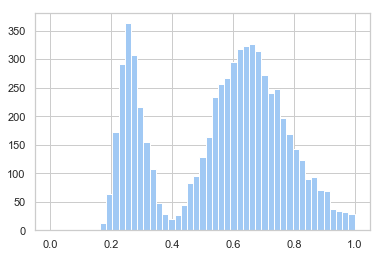

In [138]:
kk = df['Swim'] / pd.Timedelta(hours=1) #run_bike_swim[run_bike_swim['Type'] == 'Swim']['FinishTime'] 

bins = np.linspace(0, 1, 50)
plt.hist(kk, bins, density=False)

# kk.plot()

In [142]:
0.67 * 60

40.2

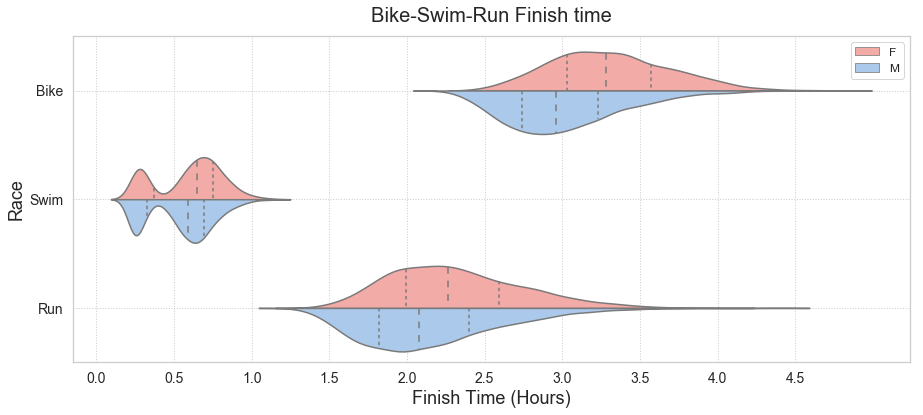

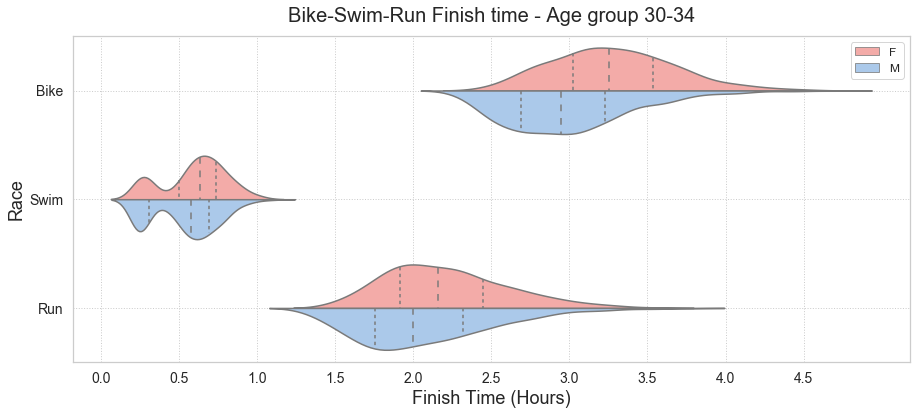

In [143]:
def plot_race_dist(input_df, title_txt, save_name):
    fig = plt.figure(figsize=(15, 6))
    sns.set(style="whitegrid", palette="pastel", color_codes=True)

    sns.violinplot(y="Type", x="FinishTime", hue='Gender', data=input_df,
                   split=True, inner="quart", palette={"M": "b", "F": "r"})

    plt.xlabel('Finish Time (Hours)', fontsize = ax_fontsize + 4)
    plt.ylabel("Race", fontsize = ax_fontsize + 4)
    plt.xticks(np.linspace(0, 4.5, 10), fontsize = ax_fontsize)  
    plt.yticks(fontsize = ax_fontsize) 

    plt.grid(linestyle='dotted')
    plt.legend(loc=0, fontsize = ax_fontsize - 2)
    plt.title(title_txt, fontsize = ax_fontsize + 6, y=1.025)

    plt.savefig(save_name, dpi=800)
    plt.show()
    
title_txt = 'Bike-Swim-Run Finish time'
save_name = 'eachrace_violin.png'
plot_race_dist(rbs, title_txt, save_name)

title_txt = 'Bike-Swim-Run Finish time - Age group 30-34'
save_name = 'eachrace_violin_30-34.png'
plot_race_dist(rbs_thirty, title_txt, save_name)

# Hotlanta 2015 Result

Show where I stand. 

In [144]:
hot_all = pd.read_csv('../hotlanta/hotlanta_all_2015.csv')
hot = pd.read_csv('../hotlanta/hotlanta_F_25-29_2015.csv')

In [151]:
print(hot_all.shape)
hot_all.head()

(1088, 9)


,Place,Name,Bib Number,Age,Gender,Age Group,Chip Time,Gun Time,Pace
0,1,Trent Binford-walsh,3,26,M,25-29,1:14:10,1:14:10,05:40/M
1,2,Alan Ash,1202,24,M,20-24,1:18:11,1:18:11,05:58/M
2,3,Benjamin LeBlanc,55,15,M,0-19,1:22:49,1:22:50,06:19/M
3,4,Brent Fields,317,43,M,40-44,1:22:58,1:23:01,06:20/M
4,5,Tim Hawkins,41,24,M,20-24,1:25:02,1:25:03,06:29/M


In [152]:
print(hot.shape)
hot.head()

(112, 7)


,Place,Name,Bib No,Age,Overall,Gun Time,Pace
0,1,Chelsea Lloyd,56,27,80,1:44:04,07:57/M
1,2,Heather Jacobsen,179,29,82,1:44:37,07:59/M
2,3,Kelly Conron,17,28,93,1:46:13,08:06/M
3,4,Meagan McLeod,62,28,94,1:46:31,08:08/M
4,5,Denae Olberding,228,26,115,1:48:17,08:16/M


In [150]:
from scipy.stats import norm

def show_where_cdh(my_hot_df):
    data = my_hot_df['Gun Time'] / pd.Timedelta(minutes=1)
    mu, std = norm.fit(data)

    cdh = my_hot_df[my_hot_df['Name'] == 'Donghua Cai']['Gun Time']
    
    cdh_time = cdh / pd.Timedelta(minutes=1)
    print(cdh_time)
    cdh_per = np.round(norm(mu, std).cdf(cdh_time) * 100, 2)
    print("Donghua is at ", cdh_per[0], "%")
    
show_where_cdh(hot_all)
show_where_cdh(hot)

352    125.55
Name: Gun Time, dtype: float64
Donghua is at  30.42 %
23    125.55
Name: Gun Time, dtype: float64
Donghua is at  19.25 %


# Running Speed of Donghua

In [153]:
hot_data = hot_all['Gun Time'] / pd.Timedelta(hours=1)
tri_data = df['Run'] / pd.Timedelta(hours=1)

hot_data = hot_data[hot_data <=3.5]
tri_data = tri_data[tri_data <= 3.5]

tri_data.head()

0    1.633611
1    1.776111
2    1.781944
3    1.753056
4    1.710833
Name: Run, dtype: float64

In [156]:
def get_norm_arr(all_data):
    xmin, xmax = min(all_data), max(all_data)
    x = np.linspace(xmin, xmax, 100)
    mu = np.mean(all_data)
    std = np.std(all_data)
    p = norm.pdf(x, mu, std)
    return p, x, mu, std

# plot norm fit
p_hot, x_hot, hot_mu, hot_std = get_norm_arr(hot_data)
p_tri, x_tri, tri_mu, tri_std = get_norm_arr(tri_data)

print(hot_mu, hot_std)
print(tri_mu, tri_std)

2.3037518172378 0.42541387481494664
2.185359214465528 0.42457886398929334


In [168]:
hot_data.describe()

count    1070.000000
mean        2.303752
std         0.425613
min         1.236111
25%         1.993472
50%         2.264028
75%         2.553403
max         3.490833
Name: Gun Time, dtype: float64

In [169]:
tri_data.describe()

count    6532.000000
mean        2.185359
std         0.424611
min         1.203333
25%         1.865486
50%         2.133333
75%         2.455278
max         3.498611
Name: Run, dtype: float64

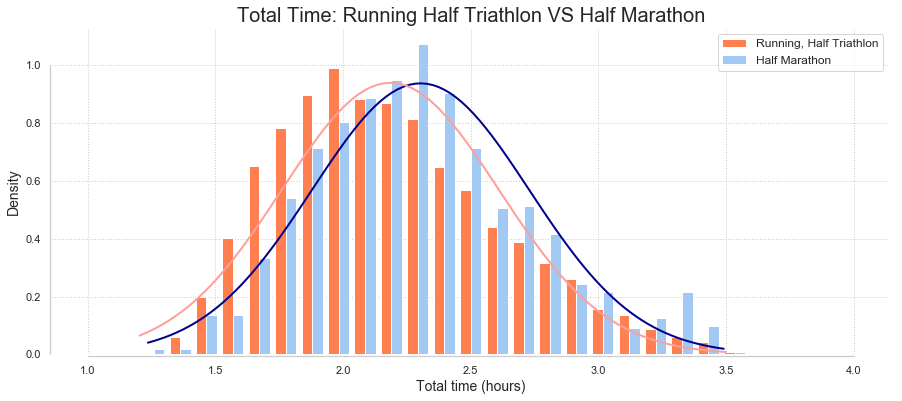

In [158]:
bins = np.linspace(1, 4, 30)
ax_fontsize = 14

# Plot histogram of total time for female and male
fig = plt.figure(figsize=(15, 6))
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# plot histogram
plt.hist([tri_data, hot_data], bins, label=('Running, Half Triathlon','Half Marathon'), density=True, color=('coral', 'b'))

# plot norm fit - Hotlanta
plt.plot(x_hot, p_hot, 'darkblue', linewidth=2)

# plot norm fit - Triathlon
plt.plot(x_tri, p_tri, 'r', linewidth=2)

plt.xlabel('Total time (hours)', fontsize = ax_fontsize)
plt.ylabel('Density', fontsize = ax_fontsize)
plt.xticks(fontsize = ax_fontsize)
plt.yticks(fontsize = ax_fontsize)

plt.grid(linestyle='dotted')
plt.legend(loc=0, fontsize = ax_fontsize - 2)
sns.despine(offset=2, trim=True)

plt.title('Total Time: Running Half Triathlon VS Half Marathon', fontsize = ax_fontsize + 6)
plt.savefig('totaltime_running_hot_tri.png', dpi=800)

plt.show()

In [164]:
cdh_time = 125.55/60
cdh_per = np.round(norm(tri_mu, tri_std).cdf(cdh_time) * 100, 2)
print("If in Triathlon Data, Donghua is at ", cdh_per, "%")

Donghua is at  41.34 %


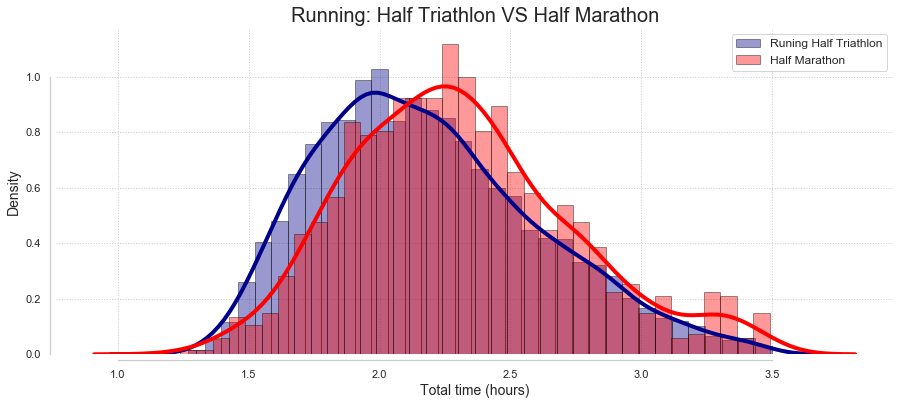

In [166]:
fig = plt.figure(figsize=(15, 6))
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.distplot(tri_data, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Runing Half Triathlon')
sns.distplot(hot_data, hist=True, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Half Marathon')

plt.xlabel('Total time (hours)', fontsize = ax_fontsize)
plt.ylabel('Density', fontsize = ax_fontsize)
plt.xticks(fontsize = ax_fontsize)
plt.yticks(fontsize = ax_fontsize)

plt.grid(linestyle='dotted')
plt.legend(loc=0, fontsize = ax_fontsize - 2)
# plt.legend(prop={'size': 16}, title = 'Airline')
sns.despine(offset=6, trim=True)

plt.title('Running: Half Triathlon VS Half Marathon', fontsize = ax_fontsize + 6)
plt.savefig('totaltime_running_tri_hot_his.png', dpi=800)

In [176]:
data_swim = df['Swim'] / pd.Timedelta(minutes=1)
swim_mu = np.mean(data_swim)
swim_std = np.std(data_swim)
print(swim_mu, swim_std)

33.878561991869915 12.642847406629116


In [177]:
cdh_per = np.round(norm(swim_mu, swim_std).cdf(53.5) * 100, 2)
print("If Swim in Triathlon Data, Donghua is at ", cdh_per, "%")

If Swim in Triathlon Data, Donghua is at  93.97 %


In [179]:
data_bike = df['Bike'] / pd.Timedelta(minutes=1)
data_bike.describe()

count    6560.000000
mean      185.886878
std        23.837091
min       130.500000
25%       168.029167
50%       183.050000
75%       200.983333
max       289.366667
Name: Bike, dtype: float64

3.3333333333333335